# NYT Crossword

## Download data

In [13]:
!rm nyt
!wget https://gist.githubusercontent.com/kedarv/db09704fa4d83507d804641fce7ab73a/raw/09b7107b1a8e7bb3d1c3cf0f4ed9236376dc4af0/nyt

--2020-01-01 20:08:07--  https://gist.githubusercontent.com/kedarv/db09704fa4d83507d804641fce7ab73a/raw/09b7107b1a8e7bb3d1c3cf0f4ed9236376dc4af0/nyt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.192.133, 151.101.128.133, 151.101.64.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61549 (60K) [text/plain]
Saving to: ‘nyt’

nyt                 100%[===================>]  60.11K  --.-KB/s    in 0.02s   

2020-01-01 20:08:07 (3.49 MB/s) - ‘nyt’ saved [61549/61549]



In [14]:
# Quick look at data format
!head -n 5 nyt

[
    {
        "author": "Ankit Pancakes",
        "time": "0:14",
        "timestamp_ms": 1576644059344


In [15]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

pd.set_option('display.max_rows', 10)

In [16]:
with open('nyt', 'r') as f:
    df = pd.read_json(f)
    # timezone bullshit
    df['timestamp_ms'] = df['timestamp_ms'].dt.tz_localize('GMT').dt.tz_convert('America/Los_Angeles')

In [17]:
display(df)

,author,time,timestamp_ms
0,Ankit Pancakes,0:14,2019-12-17 20:40:59.344000-08:00
1,Paige Rossi,0:21,2019-12-17 20:03:34.077000-08:00
2,Jenna Dambek,1:54,2019-12-17 19:49:59.569000-08:00
3,Kedar Vaidya,0:42,2019-12-17 19:21:04.959000-08:00
4,Seungyeon Shin,1:33,2019-12-17 19:18:54.673000-08:00
...,...,...,...
559,Kedar Vaidya,2:08,2019-09-16 20:46:53.663000-07:00
560,Nicky Semenza,1:36,2019-09-16 20:06:51.710000-07:00
561,Kedar Vaidya,3:05,2019-09-16 17:38:35.285000-07:00
562,Nicky Semenza,1:34,2019-09-15 16:03:10.465000-07:00


## Clean up data

In [18]:
# Days and cut-off hour (mini release time)
# 7 PM Pacific for Monday - Friday inclusive
# 3 PM Pacific for Saturday, Sunday
cutoff = lambda x: 19 if x < 5 else 15

In [19]:
[cutoff(x) for x in range(0,7)]

[19, 19, 19, 19, 19, 15, 15]

In [20]:
# Use newspaper-day instead of completion-day
df['day'] = [datetime.date(ts.year, ts.month, ts.day) + datetime.timedelta(days=1) \
            if ts.hour >= cutoff(ts.dayofweek) else datetime.date(ts.year, ts.month, ts.day) for ts in df['timestamp_ms']]

In [21]:
find_dups = lambda x: x[x.duplicated(['author', 'day'], keep=False)]
display(find_dups(df))

,author,time,timestamp_ms,day
36,Jessica Jiang,1:26,2019-12-13 20:02:53.918000-08:00,2019-12-14
37,Jessica Jiang,1:28,2019-12-13 20:01:08.854000-08:00,2019-12-14
65,Jessica Jiang,10:04,2019-12-09 20:39:11.843000-08:00,2019-12-10
66,Jessica Jiang,10:04,2019-12-09 20:39:00.040000-08:00,2019-12-10
128,Ankit Pancakes,0:41,2019-12-01 22:18:33.158000-08:00,2019-12-02
...,...,...,...,...
533,Kedar Vaidya,2:59,2019-10-03 19:39:31.028000-07:00,2019-10-04
534,Usmann Khan,1:42,2019-10-03 19:35:03.192000-07:00,2019-10-04
537,Usmann Khan,1:28,2019-10-03 19:29:35.912000-07:00,2019-10-04
549,Ankit Pancakes,2:30,2019-09-29 10:00:45.619000-07:00,2019-09-29


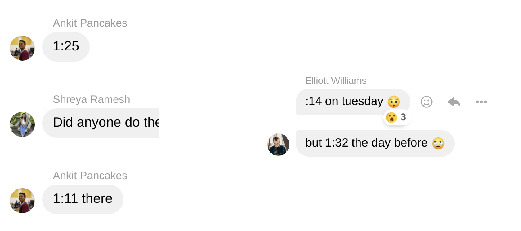

In [22]:
# Example duplicates ...
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(mpimg.imread('dup1.png'))
ax[1].imshow(mpimg.imread('dup2.png'))

In [23]:
# Delete all duplicates because I can't be bothered to scroll to each one in chat and look at them
print('before: {} dups in {} rows'.format(len(find_dups(df)), len(df['author'])))
df = df.drop_duplicates(['author', 'day'], keep=False)
print('after: {} dups in {} rows'.format(len(find_dups(df)), len(df['author'])))

before: 42 dups in 564 rows
after: 0 dups in 522 rows


## Analyze Data